In [5]:
import os 

from dotenv import load_dotenv
load_dotenv()


OLLAMA_URL=os.getenv("OLLAMA_URL")
LLM_MODEL=os.getenv("LLM_MODEL")
EMBEDDING_MODEL=os.getenv("EMBEDDING_MODEL")
DATAPATH=os.getenv("DATAPATH")
#OLLAMA_URL='http://localhost:11434'
#LLM_MODEL="llama3.2:3b" # max retires
# LLM_MODEL="gemma3:4b" # no tool support
#LLM_MODEL="qwen2.5-coder:1.5b" # no tool support
#LLM_MODEL="deepseek-r1:1.5b" # does not support tools
#os.setenv("no_proxy=localhost,127.0.0.1,*.my-it-solutions.net,ollama")

print(OLLAMA_URL)
print(f"model: {LLM_MODEL}")
print(f"embedding: {EMBEDDING_MODEL}")
print(f"datapath {DATAPATH}")
print(f"no_proxy {os.getenv('no_proxy')}")

http://ollama-service-internal.default.svc.cluster.local:11433
model: llama3.2:3b
embedding: bge-m3:567m
datapath /app/data
no_proxy None


Test connection to ollama

In [2]:
import requests
import time

response = requests.get(OLLAMA_URL,timeout=3)
if response.status_code == requests.codes.ok:
    print(response)
else:
    print(response)    

<Response [200]>


Initialize LLM

In [3]:
from llama_index.llms.ollama import Ollama
llm = Ollama(model=LLM_MODEL, request_timeout=120.0, base_url=OLLAMA_URL, temperature=0)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /opt/venv/lib/python3.13/site-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings, PromptTemplate
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.core.node_parser import SentenceSplitter

documents = SimpleDirectoryReader(
    input_files=[f"{DATAPATH}/testdata.txt",f"{DATAPATH}/additionalinfo.txt"]
).load_data()
print("loaded")

Settings.embed_model = OllamaEmbedding(model_name=EMBEDDING_MODEL, base_url=OLLAMA_URL,embed_batch_size=100)
Settings.text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=30)
# ollama
Settings.llm = llm

index = VectorStoreIndex.from_documents(
documents,
#embed_model=ollama_embedding,
)
print("finish")

loaded
finish


Demo data

In [7]:
messages = [{ "From": "Marco.Polo@wtc.com<Marco Polo>", "To": "Boris@arm.ru<Boris Invanovic>", "Subject": "Lieferung", 
            "Content": "Eine neue Lieferung steht bereit. Wir senden sie morge mit dem Flug TK9518 nach BEG"}
            ,{ "From": "Boris@arm.ru<Boris Invanovic>", "To": "Chef51@mega.de", "Subject": "Info", 
            "Content": "Morgen können die neuen Bananen in BEG abgeholt werden. Grüsse Bo"} #nick name Bo
]


Extract Entities

In [8]:
from pydantic import BaseModel, Field
from typing import List, Optional

class Person(BaseModel):
    """Person entity."""
    name: str = Field(
        ..., description="The name of a person"
    )
    nickname: str = Field(
        ..., description="The nickname of a person"
    )
    email: str = Field(
        ..., description="The email address of a person"
    )    

class Organization(BaseModel):
    """Organization entity"""
    name: str

class PersonList(BaseModel):
    persons: List[Person]
    
class OrganizationList(BaseModel):        
    organizations: List[Organization]




def add_person_list(new_persons: PersonList, existing_list: Optional[PersonList] = None) -> PersonList:
    """
    Add a person list to an empty or existing array of persons.
    
    Args:
        new_persons: A PersonList object containing persons to be added
        existing_list: An optional existing PersonList object to add to
    
    Returns:
        A new PersonList containing the merged list of persons
    """
    if existing_list is None:
        return new_persons
    
    # Create a new list with all persons from both lists
    merged_persons = PersonList(persons=existing_list.persons + new_persons.persons)
    return merged_persons   
    

In [10]:
# Knowledge base
import json
knowledge_person = []
knowledge_person_plain = []

#add_person_list(PersonList(Person=[{"name":"Mario","nickname":"MarioBo","email":"ma@acme.com"}]).Person,knowledge_person)

people = PersonList(persons=[
    {"name": "John", "nickname": "Johnny", "email": "john@example.com"},
    {"name": "Jane", "nickname": "Janie", "email": "jane@example.com"},
])
print(people)
                    
person = Person(
    name="John Doe",
    nickname="Johnny",
    email="john@example.com"
)
print(person)
json_data = '{"name": "Bob Johnson", "nickname": "Bobby", "email": "bob@example.com"}'
data_dict = json.loads(json_data)
person = Person.model_validate(data_dict)
print(person)

persons=[Person(name='John', nickname='Johnny', email='john@example.com'), Person(name='Jane', nickname='Janie', email='jane@example.com')]
name='John Doe' nickname='Johnny' email='john@example.com'
name='Bob Johnson' nickname='Bobby' email='bob@example.com'


Save new entities to memmory

In [46]:
from llama_index.program.openai import OpenAIPydanticProgram
from llama_index.core.extractors import PydanticProgramExtractor
import nest_asyncio

nest_asyncio.apply()

EXTRACT_TEMPLATE_STR = """\
Here is the content of the section:
----------------
{context_str}
----------------
Given the contextual information, extract out all person object.
A Person entity consists of: name, email.
Only use the context information. Do not assume any other facts.
Your output MUST follow this json EXACT format with EXACT field names:\n\n
[{"Persons:[{"name":"Person Name"},{"email":[Email address],"nickname":{Nickname}}}]}  ]
\
"""

EXTRACT_TEMPLATE_STR1 = """\
Given the contextual information, extract a list of persons.
If no persons are found return an emtpy list.
Only use the context information. Do not assume any other facts.
Your output MUST follow this json EXACT format with EXACT field names:\n\n
PersonList(persons=[
    {"name": "John", "nickname": "Johnny", "email": "john@example.com"},
    {"name": "Jane", "nickname": "Janie", "email": "jane@example.com"},
])
The output MUST be always a JSON Array.
Only respond in the correct format, do not include additional properties in the JSON.\n
"""
EXTRACT_TEMPLATE_STR2 = """\
From the provided context, extract a list of persons mentioned in the text.

Each person MUST include:
"name": Full name of the person.
"nickname": Nickname if mentioned, otherwise use an empty string "".
"email": Email address if mentioned, otherwise use an empty string "".
Constraints:

Do NOT assume or invent any information not explicitly present in the context.
If no persons are found, return an empty list: PersonList(persons=[]).
Always respond with ONLY valid JSON following this EXACT structure (no extra text, no explanations):
json
Copy
Edit
PersonList(persons=[
    {"name": "John", "nickname": "Johnny", "email": "john@example.com"},
    {"name": "Jane", "nickname": "Janie", "email": "jane@example.com"}
])
All fields MUST be present for each person, even if empty.
The output MUST always be a valid JSON array inside PersonList, even when empty.
Context to analyze:
"""

# extract only entities
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIModel

ollama_model = OpenAIModel(model_name=LLM_MODEL, base_url=f"{OLLAMA_URL}/v1")
                     
#agent = Agent(model=ollama_model, result_type=str,system_prompt=EXTRACT_TEMPLATE_STR,retries=3)
# deps_tpye is the input 
#agent = Agent(model=ollama_model,result_type=PersonList,deps_type=str,system_prompt=EXTRACT_TEMPLATE_STR1,retries=4)
agent = Agent(model=ollama_model,result_type=str,deps_type=str,system_prompt=EXTRACT_TEMPLATE_STR2,retries=1)
#TODO

#import json
#PersonList_schema = PersonList.model_json_schema()  # (1)!
#print(json.dumps(PersonList_schema, indent=2))  # (2)!
#print(json.dump())
knowledge_person_plain = []
for message in messages:
    print(f"query: {message}")
    entity_result = agent.run_sync(f"{message}")
    print(entity_result.data) 
    #print(len(entity_result.data))
    if isinstance(entity_result, PersonList):
        add_person_list(knowledge_person.data)
    if len(entity_result.data) > 2:        
        knowledge_person_plain.append(entity_result.data)
        print(entity_result.data)
    print("***")

print("------------------")
print(knowledge_person_plain)
#print(entity_result.data)
#print(entity_result.usage())
#memory.save(org_result.data)

#print(entity_result.model_dump())

query: {'From': 'Marco.Polo@wtc.com<Marco Polo>', 'To': 'Boris@arm.ru<Boris Invanovic>', 'Subject': 'Lieferung', 'Content': 'Eine neue Lieferung steht bereit. Wir senden sie morge mit dem Flug TK9518 nach BEG'}
```
json
PersonList(persons=[
    {"name": "Marco Polo", "nickname": "Marco Polo", "email": "Marco.Polo@wtc.com"},
    {"name": "Boris Invanovic", "nickname": "Boris", "email": "Boris@arm.ru"}
])
```
```
json
PersonList(persons=[
    {"name": "Marco Polo", "nickname": "Marco Polo", "email": "Marco.Polo@wtc.com"},
    {"name": "Boris Invanovic", "nickname": "Boris", "email": "Boris@arm.ru"}
])
```
***
query: {'From': 'Boris@arm.ru<Boris Invanovic>', 'To': 'Chef51@mega.de', 'Subject': 'Info', 'Content': 'Morgen können die neuen Bananen in BEG abgeholt werden. Grüsse Bo'}
json
[
  {
    "name": "Boris Invanovic",
    "nickname": "Boris",
    "email": "Boris@arm.ru"
  },
  {
    "name": "",
    "nickname": "",
    "email": ""
  }
]
json
[
  {
    "name": "Boris Invanovic",
    "nick

Relation Agent

In [70]:
# relation talk / known

RELATE_TEMPLATE_STR = f"""\
Task:
From the provided data, extract a graph of persons and their relationships.

Graph structure:

Nodes: Each person identified in the "Entities to analyze".
Edges: Represent relationships between persons based on message content.
Types of relations (edges):

"talk": Two persons talk directly to each other.
"known": The content indicates that one person knows another (e.g., mentions them as a known contact, friend, colleague).
Constraints and Output Rules:

ONLY use persons listed under "Entities to analyze" for nodes. Do not invent persons.
If no relations are found, return an empty "edges" list.
Always return a valid JSON object matching EXACTLY the structure shown in the example.
DO NOT add any explanatory text or comments. Only output the JSON.
All node IDs must match person names exactly as listed in "Entities to analyze" (case sensitive).

Example output:

json
Copy
Edit
{{
  "graph": {{
    "nodes": {{
      "Person1": {{"name": "John"}},
      "Person2": {{"name": "Alice"}}
    }},
    "edges": [
      {{
        "source": "Person1",
        "target": "Person2",
        "relation": "talk"
      }}
    ]
  }}
}}
Important:

Use exact names from "Entities to analyze" as node IDs.
Always include all persons as nodes, even if they have no edges.
Follow exact JSON field names and structure as shown.


Data to analyze:
"""

rel_agent = Agent(model=ollama_model,result_type=str,deps_type=str,system_prompt=RELATE_TEMPLATE_STR,retries=1)
knowledge_person_plain

relation_result = rel_agent.run_sync(f"""{messages} entities: {knowledge_person_plain}""")

#print(relation_result)
print(json.dumps(json.loads(relation_result.data), indent=4))


{
    "graph": {
        "nodes": {
            "Marco Polo": {
                "name": "Marco Polo"
            },
            "Boris Invanovic": {
                "name": "Boris Invanovic",
                "email": "Boris@arm.ru"
            }
        },
        "edges": [
            {
                "source": "Marco Polo",
                "target": "Boris Invanovic",
                "relation": "talk"
            }
        ]
    }
}



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


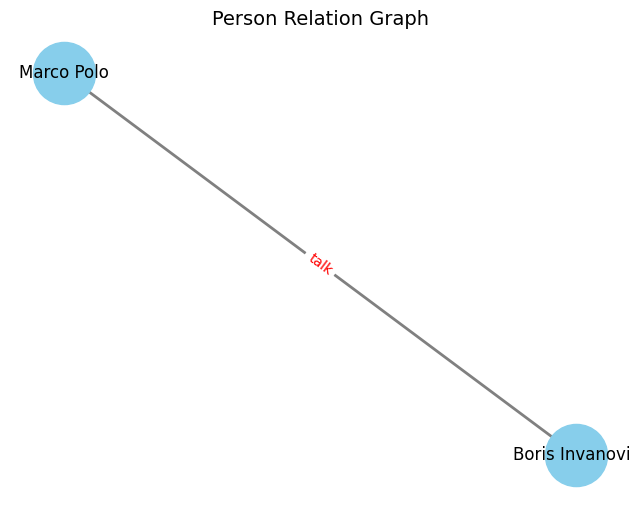

In [73]:
%pip install matplotlib

import json
import networkx as nx
import matplotlib.pyplot as plt

# --- Step 1: Your graph JSON data ---
graph_data = json.loads(relation_result.data)

# --- Step 2: Create a NetworkX graph ---
G = nx.Graph()

# Add nodes
for node_id, node_info in graph_data["graph"]["nodes"].items():
    label = node_info["name"]
    nickname = node_info.get("nickname", "")
    if nickname:
        label += f' ("{nickname}")'  # Append nickname if available
    G.add_node(node_id, label=label)

# Add edges with relation as attribute
for edge in graph_data["graph"]["edges"]:
    G.add_edge(edge["source"], edge["target"], relation=edge["relation"])

# --- Step 3: Draw the graph ---
plt.figure(figsize=(8, 6))

# Positions for all nodes
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_labels(G, pos, labels={n: d['label'] for n, d in G.nodes(data=True)}, font_size=12)

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# Draw edge labels (relation type)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

plt.axis('off')  # Hide axes
plt.title('Person Relation Graph', fontsize=14)
plt.show()

In [13]:
from datetime import date
from pydantic_ai import RunContext

@agent.system_prompt
def add_the_date() -> str:  
    return f'The date is {date.today()}.'

result = agent.run_sync('What is the date?', deps='Frank')
print(result.data)

The current date is: 2025-03-13


Extract data from image (only works with a model supporting images)

In [28]:
from pydantic_ai import ImageUrl
EXTRACT_IMG_TEMPLATE_STR = """\
Extract all possible information from the image.
----------------
{context_str}
----------------
A Person entity consists of: name, email.
Only use the context information. Do not assume any other facts.
Your output MUST follow this json EXACT format with EXACT field names:\n\n
{"persons:[{"name":[Person Name]},{"email":[Email address],"birthdate":[birthdate],"nationality":[nationality]}]}  
\
"""
agentImage = Agent(model=ollama_model,result_type=Person,system_prompt=EXTRACT_IMG_TEMPLATE_STR,retries=3)
result = agentImage.run_sync(
    [
        '',
        ImageUrl(url='file:///data/img/DO_UKR_AV.jpg'),
    ]
)
print(result.data)

ModelHTTPError: status_code: 400, model_name: llama3.2:3b, body: {'message': 'invalid image input', 'type': 'invalid_request_error', 'param': None, 'code': None}

In [ ]:
from pydantic_core import to_jsonable_python
from pydantic_ai.messages import ModelMessagesTypeAdapter

history_step_1 = entity_result.all_messages()
as_python_objects = to_jsonable_python(history_step_1)  
same_history_as_step_1 = ModelMessagesTypeAdapter.validate_python(as_python_objects)

entity_result2 = agent.run_sync(  
    f'add entities from this message: {message2}', message_history=same_history_as_step_1
)

print(entity_result2) 

In [14]:
from llama_index.core.tools import QueryEngineTool

query_engine = index.as_query_engine(similarity_top_k=3)

knowledge_tool = QueryEngineTool.from_defaults(
    query_engine,
    name="knowledge_tool",
    description="""A RAG engine with some basic facts persons. Ask natural-language questions about persons and their properties and relations.
              if the knowledge_tool has no relatied information, ignore the answer.
              """
)

In [15]:
from llama_index.core.tools import FunctionTool

# generate_kwargs parameters are taken from https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct
def find_person(name: str, **kwargs):
    """
    provides information about known persons. including ther detail information like birthdate

    args:
        name
    """
    # Mock response; replace with real query logic
    person_data = {
        "anna gölding": {"birthdate": "October 24, 1734", "known_for": "Last witch executed in Switzerland.","object_id":"1234","relations":{"knows other person":"ron paul","organzation":"pilz mafia"}},
        "john doe": {"birthdate": "Unknown", "known_for": "Placeholder name for anonymous individuals."},
        "ron paul": {"birthdate": "May 1, 1928", "known_for": "Talking a lot."},
        "miranda meyers": {"birthdate": "Aug 11, 1998", "known_for": "Miranda verkauft gerne verdorbens Eis. Das Eis erhält sie illegal von Litauen, wo es mit Mäusemilch hergestellt wird."},
    }
    return person_data.get(name.lower(), "No information available for this person.")

find_person_tool = FunctionTool.from_defaults(
    fn=find_person,
    name="find_person",
)


def find_organization(name: str, **kwargs):
    """
    provides information about known official and inofficial organzations.

    args:
        name
    """
    # Mock response; replace with real query logic
    org_data  = {
        "un": {"name": "United Nations", "description": "The Security Council has primary responsibility for the maintenance of international peace and security.","id":"200","relations":{""}},
        "pilz mafia": {"name": "Pilz Mafia", "description": "","id":"201","members":{"anna gölding","ron paul"}},
        "acme company": {"name":"acme company","description":"placeholder company"},
    }
    return org_data.get(name.lower(), "No information available for this organization.")

find_orgnization_tool = FunctionTool.from_defaults(
    fn=find_organization,
    name="find_organization",
)

#def get_messages(name: str, min_daterange: datetime, max_daterange: datetime):
def get_messages(name: str, min_daterange: str, max_daterange: str, **kwargs):
    """
    Retrieve information about communications between two or more people within a given date range.

    # Example usage:
        name = "c1"
        min_daterange = ISO8601 date string
        max_daterange = ISO8601 date string
        messages = get_messages(name, min_daterange, max_daterange)

    Args:
        name (str): The name of the context always use c1.
        min_daterange (datetime): The start of the date range.
        max_daterange (datetime): The end of the date range.

    Returns:
        dict: A dictionary of messages for the given name within the date range.
    """
    # Mock response; replace with real query logic
    min_daterange_ts = parser.parse(min_daterange)
    max_daterange_ts = parser.parse(max_daterange)
    org_data = {
        "c1_1738446338": {"sender": "Ron Paul", "message": "Anna Gölding ist gestorben.", "timestamp": datetime(2025, 1, 1)},
        "c1_1738446338": {"sender": "Pilz Mafia", "message": "Hat Sie mit Boris Weed gesprochen oder ihn erwähnt? Sie wollte von ihm ein Sack voll Vogelfutter kaufen.", "timestamp": datetime(2025, 1, 5)},
    }

    result = {}
    for key, value in org_data.items():
        if key.startswith(name.lower()): # and min_daterange_ts <= value["timestamp"] <= max_daterange_ts:
            result[key] = value

    if not result:
        return "No information available for this timerange"

    return result

get_messages_tool = FunctionTool.from_defaults(
    fn=get_messages,
    name="get_messages",
)


In [18]:
tools = [
    find_person_tool,
    find_orgnization_tool,
    get_messages_tool,
    knowledge_tool,
]

#memory = ChatMemoryBuffer(token_limit=2000)


# extract only entities
from pydantic import BaseModel
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIModel

class Organization(BaseModel):
    """Organization entity"""
    name: str

ollama_model = OpenAIModel(model_name=LLM_MODEL, base_url=f"{OLLAMA_URL}/v1")
#ollama_model = OpenAIModel(model_name='ollama:llama3.2', base_url=OLLAMA_URL)
agent = Agent(ollama_model, result_type=Organization,system_prompt=EXTRACT_TEMPLATE_STR)
#TODO



In [21]:
import nest_asyncio

nest_asyncio.apply()

prod_data = ["Die Pilz Mafia ist eine Organisation.", "Die Polnische Polizei überwacht die Pilz Mafia."]

org_result = agent.run_sync(f'What organizations are mentioned {prod_data}')
print(org_result.data)
print(org_result.usage())
#memory.save(org_result.data)


UnexpectedModelBehavior: Exceeded maximum retries (1) for result validation

In [31]:
from llama_index.core.agent import ReActAgent
from llama_index.core.memory import ChatMemoryBuffer, ChatSummaryMemoryBuffer

memory = ChatMemoryBuffer(token_limit=2000)
agent = ReActAgent.from_tools(tools, llm=llm, verbose=True, context=context, tool_choice='auto',max_iterations=25, timeout=3000, memory=memory) #, chat_history=memory)

# update agent system prompt
react_system_prompt = PromptTemplate(react_system_header_str)
agent.update_prompts({"agent_worker:system_prompt": react_system_prompt})
agent.reset()
print("start prompt")
#prompt = "Who is Anna Gölding and what other person may be related to her? to which organzations may she be related?"
question_context = """context: c1, zeitbereich: 2025-02-01T00:00:00+00:00 to 2025-02-15T00:00:00+00:00"""
prompt = f"""Wer war Anna Gölding und welche andren personen oder organisationen stehen mit ihr in verbindung?"""
xprompt = f"""Wer war Anna Gölding und welche andren personen oder organisationen stehen mit ihr in verbindung?
             Liste alle informationen und fakten die du findest in der antwort auf.
            questions context: {question_context}
            1. Analysiere die Person bekannt ist im find person tool.
            2. Analysiere die Person verbindungen zu anderen Personen oder Organisationen hat
            3. Prüfe ob Nachriten (messages) im context dieser Personen im gesuchten Zeitbereich statgefunden haben mit dem get_messages tool.
            4. Nenne die Anzahl der conversationen
            5. Nenne die Teilnehmer der conversationen
            6. Fasse den Inhalt der Kommunikation zusammen
            7. Prüfe ob Entitäten wie Personen, Organisationen oder Orte in der Nachrichten vorkommen, die bisher nicht bekannt sind.
            8. Kontrolliere ob alle Punkte dieser liste erfüllt sind
          """
response = agent.query(prompt)
#response = llm.complete(prompt)

#memory.save_context({"input": prompt}, {"output": str(response)})

print(f"AI: {response}")

start prompt
> Running step 78b703d0-8182-4034-b40a-ab0edbc366cc. Step input: Wer war Anna Gölding und welche andren personen oder organisationen stehen mit ihr in verbindung?


ReadTimeout: timed out